In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ecell4 import *
from ecell4_base.core import *
from ecell4_base import sgfrd

SCK theory (long time assumption)
done by W.X. Chew et al.

In [2]:
# SCK theory (relative error becomes less than 1% when 100R^2/D <= t)
def calc_k(ka, D, R, t):
    if t == 0:
        return ka

    kappa = ka / D
    gamma = 0.5772156
    # Cc    = 4 * D / (R**2) * np.exp(4 * np.pi / kappa - 2 * gamma)
    # to avoid numerical error
    lnCct = 4 * np.pi / kappa - 2 * gamma + np.log(4 * D / (R**2)) + np.log(t)
    return 4 * np.pi * D * (1.0 / lnCct - gamma / (lnCct**2) - 1.311 / (lnCct**3) + 0.25 / (lnCct**4))

def calc_S(ka, D, R, concB, delta_t, total_t):
    steps = int(total_t / delta_t) + 1
    ks = [calc_k(ka, D, R, (tau+0.5) * delta_t) for tau in range(0, steps+1)]
    return ([tau * delta_t for tau in range(0, steps)],
            [np.exp(-concB * sum(k * delta_t for k in ks[0:tau])) for tau in range(0, steps)])

parameter setting

In [3]:
# system size and number of particles
L     = np.sqrt(10.0)
el    = Real3(L, L, L)
NA    = 100
NB    = 100
concA = NA / (L * L)
concB = NA / (L * L)

# physical parameters of species
rA = 0.005
rB = 0.005
DA = 1.0
DB = 0.0
R = rA + rB
D = DA + DB

ka = np.pi * 4.0

duration = 0.2
steps    = 50
ts       = np.linspace(0, duration, steps+1)
delta_t  = duration / steps

N = 30  # a number of samples

In [4]:
# initial condition
y0 = {'A': NA, 'B': NB}

In [5]:
# model
with species_attributes():
    A | {'radius': rA, 'D': DA}
    B | {'radius': rB, 'D': DB}

with reaction_rules():
    A + B > B | ka

m = get_model()

In [6]:
rng = GSLRandomNumberGenerator()
rng.seed(0)

# obs = run_simulation(np.linspace(0, duration, steps+1), y0, volume=el, model=m, return_type='observer', solver='sgfrd')
obs = ensemble_simulations(ts, y0, volume=el, model=m, return_type='observer', solver='sgfrd', n=N)

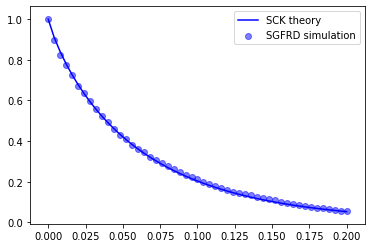

In [7]:
# viz.plot_number_observer(obs)
t_nume = [time_frame[0]      for time_frame in obs.data()]
S_nume = [time_frame[1] / NA for time_frame in obs.data()]
t_theo, S_theo = calc_S(ka, D, R, concB, delta_t, duration)

plt.plot   (t_theo, S_theo, label="SCK theory",       color="blue")
plt.scatter(t_nume, S_nume, label="SGFRD simulation", color="blue", alpha=0.5)
plt.legend()

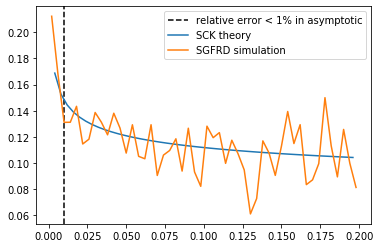

In [8]:
A_nume = obs.data()
t_nume = [(A_nume[t][0] + A_nume[t+1][0]) * 0.5 for t in range(len(A_nume)-1)]
k_nume = [(A_nume[t][1] - A_nume[t+1][1]) / delta_t / (0.5 * (A_nume[t][1] + A_nume[t+1][1])) / concB / ka for t in range(len(A_nume)-1)]

# since the theoretical formula is a long time asymptotic, it becomes irregular at t <= R^2/D.
# Therefore it skips t[0] here.
k_theo = [calc_k(ka, D, R, t) / ka for t in ts[1:-1]]

plt.axvline(x = 100 * R**2 / D, color='k', linestyle='--', label="relative error < 1% in asymptotic")
plt.plot(ts[1:-1], k_theo, label="SCK theory")
plt.plot(t_nume,   k_nume, label="SGFRD simulation")
plt.legend()
